### Cartpole example using A3C RL agent 
The A3C model uses loss function that has generalized advantage estimation added. 

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.multiprocessing as mp
from torch.autograd import Variable

import matplotlib.pyplot as plt
import gym
import os
import numpy as np
import pandas as pd

In [3]:
from worker import Worker
from net import Net
from shared_adam import SharedAdam

In [6]:
def setup_environment(): 
    game = 'CartPole-v0'
    env = gym.make(game)
    env._max_episode_steps = 500
    state_dim = env.observation_space.shape[0]
    action_dim = env.action_space.n
    return env, state_dim, action_dim
    

def setup_parallel_workers(max_episodes):
    # Define shared model and optimizer
    env, state_dim, action_dim = setup_environment()
    shared_model = Net(state_dim, action_dim)
    shared_model.share_memory()
    optimizer = SharedAdam(shared_model.parameters(), lr=1e-4, betas=(0.9, 0.999))    

    # Multiprocessor environment
    os.environ["OMP_NUM_THREADS"] = "1"

    global_episode_ctr = mp.Value('i', 0)
    res_queue = mp.Queue()
    n_worker = mp.cpu_count()
     
    workers = []
    for i in range(n_worker):
        render = False

        # Local model and environment
        local_model = Net(state_dim, action_dim)
        environment, _, _ = setup_environment()
        
        # Local worker
        worker = Worker(
            shared_model, 
            local_model, 
            optimizer, 
            global_episode_ctr, 
            max_episodes, 
            res_queue, 
            render, 
            environment
        )
        workers.append(worker)

    return workers, res_queue, shared_model


def run_parallel_training(workers, res_queue):

    # Start training
    for worker in workers:
        worker.start()

    # Collect results
    results = [] 
    n_ready = 0
    while True:
        result = res_queue.get()
        if result is not None:
            results.append(result)
            if result['episode'] % 25 == 0:
                print('Episode: {} reward: {:0.1f}'.format(result['episode'], result['reward']))
        else:
            n_ready += 1
        if n_ready == len(workers): 
            break
            
    for worker in workers:
        worker.join()
    
    results = pd.DataFrame(results).sort_values(by='episode').set_index('episode')
    return results

In [7]:
workers, res_queue, shared_model = setup_parallel_workers(max_episodes=500)
results = run_parallel_training(workers, res_queue)

Episode: 0 reward: 26.0
Episode: 25 reward: 15.0
Episode: 50 reward: 17.0
Episode: 75 reward: 27.0
Episode: 100 reward: 43.0
Episode: 125 reward: 40.0
Episode: 150 reward: 47.0
Episode: 175 reward: 84.0
Episode: 200 reward: 107.0
Episode: 225 reward: 74.0
Episode: 250 reward: 138.0
Episode: 275 reward: 227.0
Episode: 300 reward: 500.0
Episode: 325 reward: 302.0
Episode: 350 reward: 173.0
Episode: 375 reward: 191.0
Episode: 400 reward: 306.0
Episode: 425 reward: 134.0
Episode: 450 reward: 181.0
Episode: 475 reward: 180.0


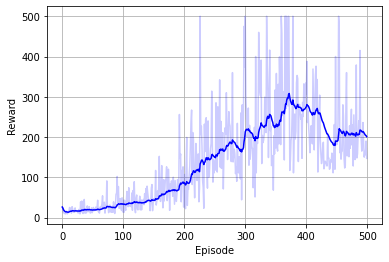

In [8]:
results['reward_ma'] = results['reward'].ewm(alpha=0.05).mean()   
plt.figure()
plt.plot(results.index.values, results['reward_ma'].values, color='blue')
plt.plot(results.index.values, results['reward'].values, color='blue', alpha=0.2)
plt.ylabel('Reward')
plt.xlabel('Episode')
plt.grid()
plt.show()

### Test

In [9]:
game = 'CartPole-v0'
env = gym.make(game)
env._max_episode_steps = 500

state = env.reset()
state = torch.from_numpy(state)
rewards = 0
done = False        
while not done: 
    env.render()
    with torch.no_grad():
        logit, value = shared_model(state.unsqueeze(0))
    prob = F.softmax(logit, dim=-1)
    action = np.argmax(prob.data.numpy())
    state, reward, done, _ = env.step(action)
    state = torch.from_numpy(state)
    rewards += reward
env.reset()
env.close()
print(rewards)

2021-12-15 23:30:16.281 Python[4072:59058] ApplePersistenceIgnoreState: Existing state will not be touched. New state will be written to (null)


316.0
